In [2]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#variable="air.2m"
#variable="air.sfc"
#variable="apcp"
variable="rhum.2m"

In [5]:
# The temperature to be used for finding the viable transmission range
temperature= "air.2m"
#temperature= "air.sfc"

In [6]:
months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years=range(1999, 2016)

In [7]:
# Importing WNV data
df= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/Arbovirus_risk_modeling_US/WNV_human_cases/WNV_NI_NNI_1999to2015_prevalence_incidence_final_20180530.csv", encoding='latin-1')
df=df[df["Select_County"]==1]
df.rename(columns = {'GEOID10':'GEOID'}, inplace = True)

In [8]:
# Defining Virus tramission temperarture range(in Fahrenheit)
a=60
b=90

In [9]:
# Converting Fahrenheit to Kelvin
a=(a-32)*5/9 + 273
b=(b-32)*5/9 + 273

In [10]:
temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + "air.2m" +"_masked/"+ "1999" + "_" + "01" + "_masked.csv")

In [11]:
# For CDD and CP
df_mod=df.copy()
for j in years:
    for k in range(len(months)):
        #Importing monthly temperature data
        temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + temperature +"_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
        #Importing monthly precipitation data
        prec=pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/apcp_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
        # Only considering mean values
        temp=temp[["GEOID", "mean"]]
        temp.rename(columns = {'mean':'mean_temp_' + str(j) + "_" + months[k]}, inplace = True)
        prec=prec[["GEOID", "mean"]]
        prec.rename(columns = {'mean':'mean_prec_' + str(j) + "_" + months[k]}, inplace = True)
        # Adding columns corresponding to all years and months
        df_mod=df_mod.join(temp.set_index('GEOID'), on='GEOID')
        df_mod=df_mod.join(prec.set_index('GEOID'), on='GEOID')

In [12]:
# Adding a column for incident year
incident_year=[2015 for i in range(len(df_mod))]
for j in range(len(df_mod)):
    for i in years:
        if(df_mod.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df_mod["Incident_year"]=incident_year

In [13]:
x_cdd=[]    #For storing cumulative degree days  
x_cp=[]     #For storing cumulative precipitation
y=[]        #For storing IR of WNV
for i in years:
    #Number of days in february
    feb=28
    #For leap year
    if(i%4==0):
        feb=29
    #Months with number of days
    days={"01":31, "02":feb, "03" :31, "04":30, "05":31, "06":30, "07":31, "08":31, "09":30, "10":31, "11":30, "12":31}
    for j in range(len(df_mod)):
        cdd=0
        cp=0
        # For all years after first incident year
        if(df_mod.iloc[j]["Incident_year"]<i):
            for k in months:
                if(df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]>=a and df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]<=b):
                    cdd=cdd + days[k]
                    cp=cp + df_mod.iloc[j]["mean_prec_" + str(i) + "_" + k]
            x_cdd.append(cdd)
            x_cp.append(cp)
            y.append(df_mod.iloc[j]["NI_IR_" + str(i)]) 

In [28]:
df_cdd=pd.DataFrame()
df_cp=pd.DataFrame()
df_cdd["IR"]=y
df_cdd["CDD"]=x_cdd
df_cp["IR"]=y
df_cp["CP"]=x_cp

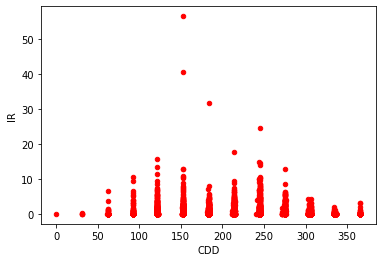

In [29]:
df_cdd.plot(kind='scatter',x='CDD',y='IR',color='red')

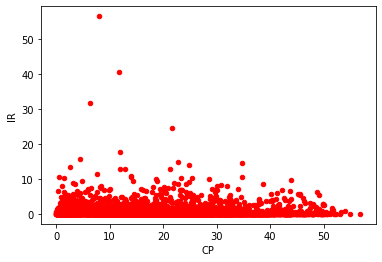

In [30]:
df_cp.plot(kind='scatter',x='CP',y='IR',color='red')

In [31]:
# For plotting standard deviations of the variable
df_mod=df.copy()
for j in years:
    for k in range(len(months)):
        #Importing monthly temperature data
        temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + temperature +"_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
        #Importing monthly data for the variable
        var=pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/narr_urban_county_data_masked/" + variable +"_masked/"+ str(j) + "_" + months[k] + "_masked.csv")
        # Only considering mean values
        temp=temp[["GEOID", "mean"]]
        temp.rename(columns = {'mean':'mean_temp_' + str(j) + "_" + months[k]}, inplace = True)
        var=var[["GEOID", "mean"]]
        var.rename(columns = {'mean':'mean_' + str(j) + "_" + months[k]}, inplace = True)
        # Adding columns corresponding to all years and months
        df_mod=df_mod.join(temp.set_index('GEOID'), on='GEOID')
        df_mod=df_mod.join(var.set_index('GEOID'), on='GEOID')

In [32]:
# Adding a column for incident year
incident_year=[2015 for i in range(len(df_mod))]
for j in range(len(df_mod)):
    for i in years:
        if(df_mod.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df_mod["Incident_year"]=incident_year

In [33]:
x=[]        #For storing temperature/precipitation/humidity standard deviation 
y=[]        #For storing IR of WNV
for i in years:
    for j in range(len(df_mod)):
        temp_list=[]
        # For all years after first incident year
        if(df_mod.iloc[j]["Incident_year"]<i):
            if(df_mod.iloc[j]["NI_IR_" + str(i)]>0):     #Removing IR=0 instances
                for k in months:
                    if(df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]>=a and df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]<=b):
                        temp_list.append(df_mod.iloc[j]["mean_" + str(i) + "_" + k])
                if(len(temp_list)>0):
                        x.append(np.std(temp_list))
                        y.append(df_mod.iloc[j]["NI_IR_" + str(i)]) 

In [34]:
df_std=pd.DataFrame()
df_std["IR"]=y
df_std["Std"]=x

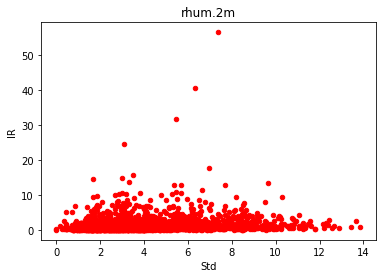

In [35]:
df_std.plot(kind='scatter',x='Std',y='IR',color='red', title= variable)

In [36]:
df_mod[df_mod["STNAME"]=="California"]

,GEOID,Select_County,STATEFP10,STATENS,STUSPS,STNAME,COUNTYFP10,COUNTYNS10,CTYNAME,POPESTIMATE1999,...,mean_2015_08,mean_temp_2015_09,mean_2015_09,mean_temp_2015_10,mean_2015_10,mean_temp_2015_11,mean_2015_11,mean_temp_2015_12,mean_2015_12,Incident_year
157,6001,1,6,1779778,CA,California,1,1675839,Alameda County,1427114,...,48.489536,294.965308,43.295074,292.466211,52.298437,283.939404,63.045660,281.723437,74.257831,2008
160,6007,1,6,1779778,CA,California,7,1675842,Butte County,201282,...,29.859396,294.292542,30.540958,290.703796,43.023621,279.582184,61.618282,276.793304,78.243530,2005
163,6013,1,6,1779778,CA,California,13,1675903,Contra Costa County,936983,...,50.654819,295.291595,44.556129,292.937927,52.584515,284.367645,62.946152,281.871857,75.259827,2005
165,6017,1,6,1779778,CA,California,17,277273,El Dorado County,154381,...,32.104321,293.453674,30.741383,289.655212,44.736858,278.870819,61.171219,276.160583,73.793556,2005
166,6019,1,6,1779778,CA,California,19,277274,Fresno County,789405,...,26.414490,293.934597,27.642739,289.592746,42.791538,279.007758,54.727441,276.299859,64.237000,2004
169,6025,1,6,1779778,CA,California,25,277277,Imperial County,141056,...,26.010128,303.777398,36.124122,298.451823,35.353339,287.979818,31.832625,283.592095,33.948988,2003
171,6029,1,6,1779778,CA,California,29,2054176,Kern County,655428,...,22.199789,298.419006,27.959677,293.769043,40.129295,283.041351,45.360001,279.862274,54.683586,2004
172,6031,1,6,1779778,CA,California,31,277280,Kings County,126402,...,22.681421,300.025537,25.590335,296.153174,39.041986,284.671753,55.701953,281.510840,65.514227,2005
175,6037,1,6,1779778,CA,California,37,277283,Los Angeles County,9437290,...,32.916279,296.580950,42.809893,293.301723,44.807251,284.437308,40.371874,281.398071,46.992270,2002
176,6039,1,6,1779778,CA,California,39,277284,Madera County,121883,...,26.698076,295.333008,27.620210,291.234511,41.749200,280.117215,57.859877,277.051921,67.927592,2005


In [37]:
#Below section is for verification of NARR data, done by plotting monthly temperatures for different counties.

In [38]:
#new=df_mod[df_mod["CTYNAME"]== "Pinal County"]

In [39]:
#new=df_mod[df_mod["CTYNAME"]== "New York County"]

In [40]:
#new=df_mod[df_mod["CTYNAME"]== "Champaign County"]

In [41]:
county="Cook County"

In [42]:
new=df_mod[df_mod["CTYNAME"]== county]

In [43]:
new

,GEOID,Select_County,STATEFP10,STATENS,STUSPS,STNAME,COUNTYFP10,COUNTYNS10,CTYNAME,POPESTIMATE1999,...,mean_2015_08,mean_temp_2015_09,mean_2015_09,mean_temp_2015_10,mean_2015_10,mean_temp_2015_11,mean_2015_11,mean_temp_2015_12,mean_2015_12,Incident_year
576,17031,1,17,1779784,IL,Illinois,31,1784766,Cook County,5365344,...,77.033035,293.483246,74.619576,285.700012,69.62619,280.398071,74.720047,277.201935,82.839401,2002


In [44]:
temp_dict={}

for i in years:
    temp=[]
    for j in months:
        temp.append((new.iloc[0]["mean_temp_" + str(i) + "_" + j] -273)*9/5 +32)
    temp_dict[i]=temp
    
month=[]
for j in months:
    month.append(int(j))

Text(0.5, 1.0, 'Cook County')

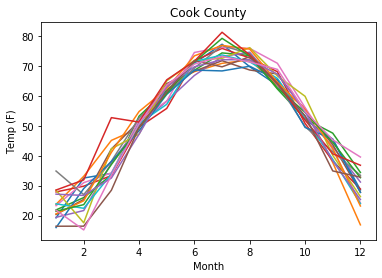

In [45]:
for i in years:
    plt.plot(month, temp_dict[i])
plt.xlabel("Month")
plt.ylabel("Temp (F)")
plt.title(county)